# Initial imports and definitions

In [240]:
import zipfile
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import geopy.distance
from matplotlib import cm
from io import StringIO
import json
from tqdm import notebook as tqdm_notebook

In [245]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import numpy as np

def plot_dendrogram(model, plot=False, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    order = dendrogram(linkage_matrix, no_plot = not plot, get_leaves=True, **kwargs)['leaves']
    return linkage_matrix, order


def elbow(data):
    elbowdata = np.array(data)
    if elbowdata.shape[1] != 2:
        elbowdata = elbowdata.T
    elbowdata -= elbowdata[0]
    rotation = np.linalg.inv(np.vstack([elbowdata[-1], [-elbowdata[-1,1], elbowdata[-1,0]]]).T)
    idx = np.argmin((elbowdata @rotation.T)[:,1])
    return idx    


def autocluster(data, return_order=False, return_linkage=False, plot=False, quiet=False, **kwargs):
    ag = AgglomerativeClustering(distance_threshold=0,n_clusters=None,**kwargs)
    ag.fit(data)
    linkage_matrix, order = plot_dendrogram(ag)
    idx = len(linkage_matrix) - elbow(list(enumerate(linkage_matrix[:,2])))
    if plot:
        plt.plot(linkage_matrix[:,2][::-1])
        plt.show()
    if not quiet:
        print("number of clusters: ", idx)
    ag2 = AgglomerativeClustering(n_clusters=idx, **kwargs)
    ag2.fit(data)
    ret = [ag2]
    if return_order:
        ret.append(order)
    if return_linkage:
        ret.append(linkage_matrix)
    return tuple(ret) if len(ret) > 1 else ret[0]

In [3]:
def plot_abq(data, first=True, **kwargs):
    if first:
        print('loading image')
        img = Image.open('abqmap2.png')
        plt.figure(figsize=(10,10))
        plt.imshow(img)
    for row in data:
        if 'latitude' in row:
            plot(row['latitude'], row['longitude'], **kwargs)
        else:
            plot(*row, **kwargs)
def plot(lat,lon,c, **kwargs):
    A = np.array([[ 3.30048468e+00, -1.76873312e+03],
       [ 1.44506111e+03, -7.69612341e+00],
       [ 1.54147586e+05,  6.14923771e+04]]).T
    pltx = A[1]@[lat,lon,1]
    plty = A[0]@[lat,lon,1]
    plt.scatter([plty], [pltx], color=c, **kwargs)

# right, need to convert lat/lon to euclidean
origin_x = -106.544256
origin_y = 35.034674
foot_x = 1
d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y, origin_x + foot_x)).feet
while abs(d-1) > 1e-5:
    if d > 1:
        foot_x *= 0.9
    else:
        foot_x *= 1.05
        
    d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y, origin_x + foot_x)).feet
foot_y = 1
d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y+foot_y, origin_x)).feet
while abs(d-1) > 1e-5:
    if d > 1:
        foot_y *= 0.9
    else:
        foot_y *= 1.05
    d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y+foot_y, origin_x)).feet
    

def ll2euclid(ptx, pty):
    pt = np.array([ptx, pty])
    pt -= [origin_y, origin_x]
    pt /= [foot_y, foot_x]
    return pt

In [229]:
def trip2array(trip, n):
    locations = np.zeros((n,2))
    msg_times = np.array([str2time(t) for t in trip['msg_time']])
    for i,t in zip(range(n), np.linspace(min(msg_times),max(msg_times),n, endpoint=False)):
        x = np.argmax(msg_times > t)
        locations[i] = ((trip['latitude'].iloc[x] + trip['latitude'].iloc[x-1])/2, (trip['longitude'].iloc[x] + trip['longitude'].iloc[x-1])/2)
    return locations

def str2time(s):
    hour,minute,second = list(map(int,s.split(':')))
    return second + 60*minute + 60*60*hour

with open('stoplocations.json') as file:
    stoplocations = json.load(file)
    
with open('stopnames.json') as file:
    stopnames = json.load(file)
    
def uniq(li):
    output = [li[0]]
    for l in li[1:]:
        if l != output[-1]:
            output.append(l)
    return output

def intersection_label(lat, lng):
    stop_distances = [ (id, geopy.distance.geodesic((lat,lng),(x['lat'], x['lng'])).feet) for id,x in stoplocations.items()]
    closest_stop, d = min(stop_distances, key=lambda x: x[1])
    if d > 100:
        return f'{round(lat,5)}, {round(lng,5)}', None
    else:
        return stopnames[closest_stop], closest_stop
    

# The analysis

In [114]:
full_days = '10_11 10_10 10_8 10_9 9_28 9_23 9_21 9_22 9_12 10_7 9_19 9_16 9_17 9_18'.split()
all_arts = []
for day in tqdm(full_days):
    with zipfile.ZipFile('../busdata/bus.zip') as file:
        with file.open(f'bus_data_2022_{day}.csv') as myfile:
            data = myfile.read()
    

    df = pd.read_csv(StringIO(data.decode()))
    arts = df[df.route_short_name=='777']
    for id in set(arts.trip_id):
        art = arts[arts.trip_id == id]
#         art = art.sort_values('msg_time', key=lambda x: [str2time(y) for y in x], kind='stable')
#         if len(uniq(art.next_stop_name.tolist())) > 28:
#             continue
        all_arts.append(art)
#         assert abs(all_arts[-1].index - all_arts[-1].sort_values('msg_time', key=lambda x: [str2time(y) for y in x], kind='stable').index).max() == 0

100%|██████████████████████████| 14/14 [00:37<00:00,  2.65s/it]


In [115]:
len(all_arts)

1450

In [119]:
trip_arrays = []
for art in tqdm(all_arts):
        trip = art.sort_values('msg_time', key=lambda x: [str2time(y) for y in x])
        trip_arrays.append(trip2array(trip,100))
trip_arrays = np.array(trip_arrays)

100%|█████████████████████| 1450/1450 [00:06<00:00, 217.65it/s]


C:\Users\patri\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


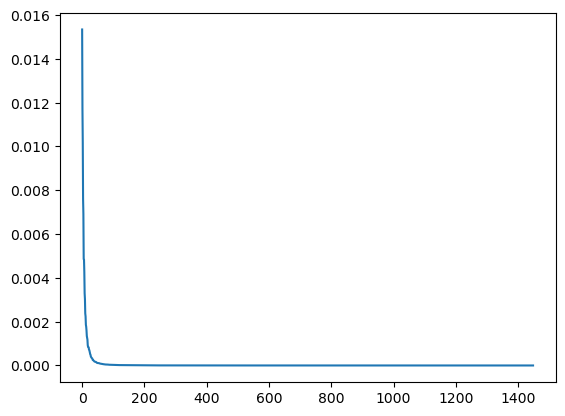

C:\Users\patri\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


number of clusters:  40


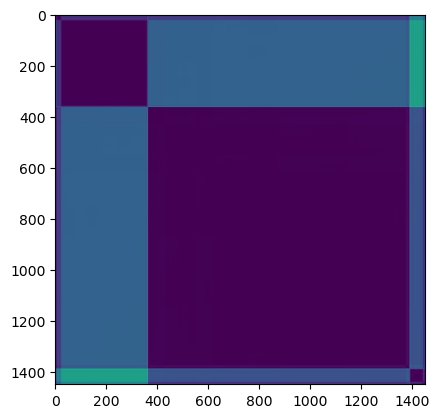

In [120]:
from scipy.stats import kendalltau
dist_mat = np.zeros((len(trip_arrays),len(trip_arrays)))
for i,t1 in enumerate(trip_arrays):
    for j,t2 in enumerate(trip_arrays[i+1:]):
        dist_mat[i,i+j+1] = abs(t1[:,0].max() - t2[:,0].max())
#         dist_mat[i,i+j+1] = kendalltau(t1[:,0],t2[:,0])[1] + kendalltau(t1[:,1],t2[:,1])[1]
#         dist_mat[i,i+j+1] = (1-kendalltau(t1[:,0],t2[:,0])[0]) * (1-kendalltau(t1[:,1],t2[:,1])[0])
#         x = ((t - np.mean(t,axis=0))*(t2 - np.mean(t2,axis=0))).sum(0)
#         y,z = np.linalg.norm((t - np.mean(t,axis=0)), axis=0),np.linalg.norm((t2 - np.mean(t2,axis=0)), axis=0)
#         dist_mat[i,i+j+1] = 1-x[0]*x[1]/(y[0]*y[1]*z[0]*z[1])
dist_mat += dist_mat.T
# .square( trip_arrays[:,None] - trip_arrays[None]).sum(-1).max(-1)**0.5
ag, lmat = autocluster(dist_mat, return_order=True, plot=True, affinity="precomputed", linkage='average')
order = lmat#['leaves']
plt.imshow(dist_mat[order][:,order])
plt.show()

In [122]:
correct_cluster = np.argmax([sum(ag.labels_==i) for i in range(ag.n_clusters)])
print("correct cluster is ", correct_cluster)
valid_arts = [ a.sort_values('msg_time', key=lambda x: [str2time(y) for y in x]) for i,a in enumerate(all_arts) if ag.labels_[i]==correct_cluster]
print(len(valid_arts))

correct cluster is  1
940


In [123]:
# filter by how close they are to real stops
real_artstop_locations = [ stoplocations[s] for s,v in stopnames.items() if 'ART' in v]
real_artstop_locations

[{'lat': 35.070248, 'lng': -106.51563300000001},
 {'lat': 35.072183, 'lng': -106.533424},
 {'lat': 35.074090000000005, 'lng': -106.55088799999999},
 {'lat': 35.066138, 'lng': -106.498065},
 {'lat': 35.073714, 'lng': -106.549733},
 {'lat': 35.071742, 'lng': -106.531578},
 {'lat': 35.069891, 'lng': -106.514582},
 {'lat': 35.080046, 'lng': -106.710101},
 {'lat': 35.082701, 'lng': -106.69833100000001},
 {'lat': 35.085698, 'lng': -106.685129},
 {'lat': 35.094381, 'lng': -106.669974},
 {'lat': 35.089636999999996, 'lng': -106.66428700000002},
 {'lat': 35.083228000000005, 'lng': -106.641049},
 {'lat': 35.082217, 'lng': -106.633021},
 {'lat': 35.081338, 'lng': -106.626478},
 {'lat': 35.081053000000004, 'lng': -106.62011799999999},
 {'lat': 35.0805, 'lng': -106.609602},
 {'lat': 35.078859, 'lng': -106.595652},
 {'lat': 35.077876, 'lng': -106.586646},
 {'lat': 35.075996, 'lng': -106.56932900000001},
 {'lat': 35.080003000000005, 'lng': -106.71013899999998},
 {'lat': 35.082669, 'lng': -106.698365},

In [124]:
# ok, now we do a different analysis: counterfactuals
valid_arts_eb = [art.sort_values('msg_time', key=lambda x: [str2time(y) for y in x], kind='stable') for art in valid_arts if art.iloc[0].longitude < art.iloc[-1].longitude]
valid_arts_wb = [art.sort_values('msg_time', key=lambda x: [str2time(y) for y in x], kind='stable') for art in valid_arts if art.iloc[0].longitude > art.iloc[-1].longitude]
print(len(valid_arts_eb), ' eastbound')
print(len(valid_arts_wb), ' westbound')

451  eastbound
489  westbound


100%|██████████████████████| 451/451 [00:00<00:00, 9113.53it/s]


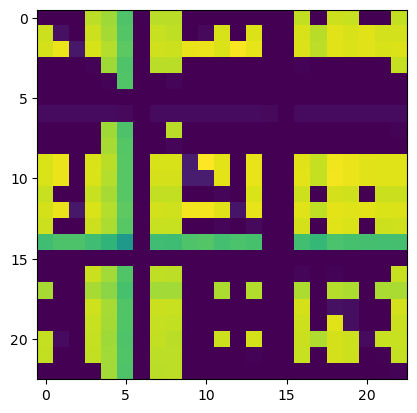

In [143]:
# now let's look at consecutive stops

eb_allstops = set()
for art in tqdm(valid_arts_eb):
    eb_allstops = eb_allstops.union(art.next_stop_id.tolist())
eb_allstops = list(eb_allstops)
priority = np.zeros((len(eb_allstops), len(eb_allstops)))

    
for art in tqdm(valid_arts_eb):
    order = uniq(art.next_stop_id.tolist())
    if len(order) > 28:
        continue
    for i,s1 in enumerate(order):
        idx1 = eb_allstops.index(s1)
        for s2 in order[i+1:]:
            idx2 = eb_allstops.index(s2)
#             assert idx1 != idx2
            priority[idx1,idx2] += 1
            

plt.imshow(priority)

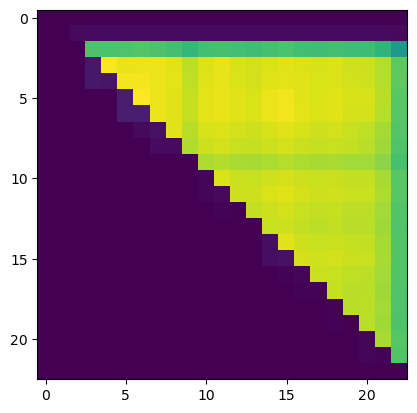

704230865
704230866
704230867
704230894
704230869
704230870
704230900
704230971
704230872
704230873
704230874
704230875
704231125
704230901
704230877
704230878
704230973
704230879
704230336
704230486
704230487


In [145]:
eb_order = np.argsort(np.linalg.norm(priority, axis=0, ord=0.1))
plt.imshow(priority[eb_order][:,eb_order])
plt.show()
eb_stops = [eb_allstops[i] for i in eb_order if 'ART' in stopnames[eb_allstops[i]]]
for i in eb_stops:
    print(i)


In [179]:
# let's look at one pair first
stop1 = eb_stops[0]
stop1_loc = stoplocations[stop1]
stop1_name = stopnames[stop1]
stop2 = eb_stops[1]
stop2_name = stopnames[stop2]
stop2_loc = stoplocations[stop2]
segments = []
for art in tqdm(valid_arts_eb):
    order = uniq(art.next_stop_id.tolist())
    if stop2 not in order:
        continue
    order = order[order.index(stop2):]
    if stop1 in order:
        continue
    d = [geopy.distance.geodesic((stop1_loc['lat'], stop1_loc['lng']), (row.latitude, row.longitude)).feet if row.speed_mph == 0 else 1000 for _,row in art.iterrows() ]
    if min(d) > 50:
        continue
    stop1_idx = np.argmin(d)
    d = [geopy.distance.geodesic((stop2_loc['lat'], stop2_loc['lng']), (row.latitude, row.longitude)).feet if row.speed_mph == 0 else 1000 for _,row in art.iterrows() ]
    if min(d) > 50:
        continue
    stop2_idx = np.argmin(d)
    assert stop1_idx != stop2_idx
    seg = art.iloc[stop1_idx:stop2_idx+1]
    if (seg.longitude.iloc[1:].to_numpy() - seg.longitude.iloc[:-1].to_numpy()).min() < 0:
        continue
    
    segments.append(seg)
print(len(segments))

100%|████████████████████████| 451/451 [00:18<00:00, 24.45it/s]

93


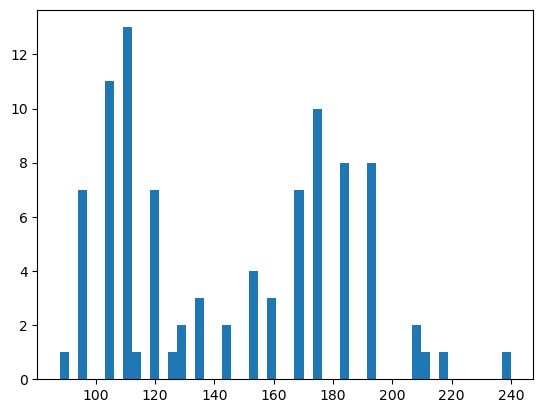

In [180]:
travel_times = [str2time(s.iloc[-1].msg_time) - str2time(s.iloc[0].msg_time) for s in segments]
plt.hist(travel_times, bins=50)
plt.show()

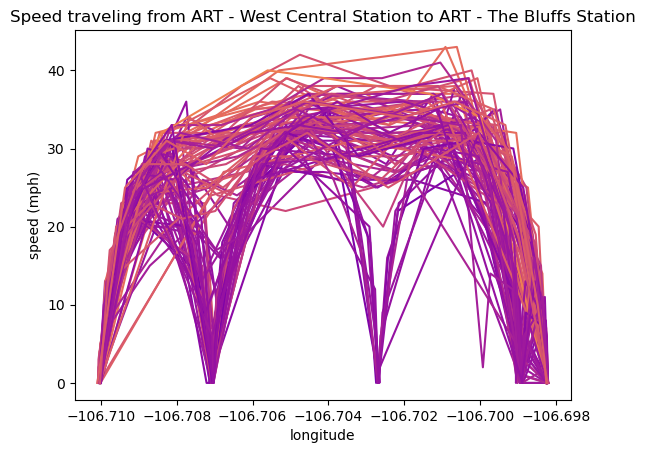

In [186]:
plt.title(f'Speed traveling from {stop1_name} to {stop2_name}')
plt.ylabel('speed (mph)')
plt.xlabel('longitude')
for s in segments:
    plt.plot(s.longitude, s.speed_mph, color=cm.plasma(60/(str2time(s.iloc[-1].msg_time) - str2time(s.iloc[0].msg_time))))
plt.show()

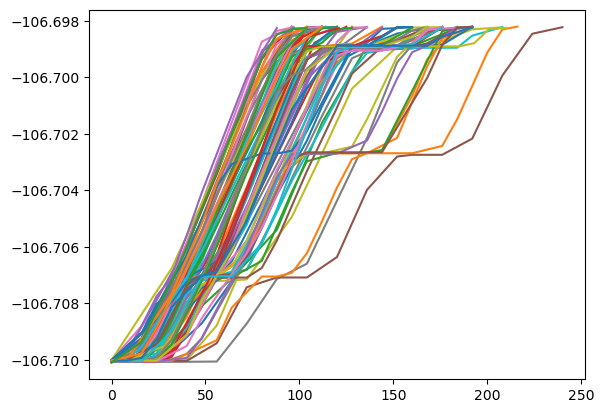

In [182]:
for s in segments:
    plt.plot([str2time(t) - str2time(s.iloc[0].msg_time) for t in s.msg_time], s.longitude)
plt.show()

In [276]:
def count_stops(speeds, limit=5):
    n_stops=0
    in_stop=False
    for s in speeds:
        if s<limit and not in_stop:
            n_stops += 1
            in_stop = True
        elif s >= limit:
            in_stop = False
    return n_stops

def where_stops(series, limit=5):
    locs=[]
    in_stop=False
    for _,s in series.iterrows():
        if s.speed_mph<limit and not in_stop:
            locs.append( ( s.latitude, s.longitude))
            in_stop = True
        elif s.speed_mph >= limit:
            in_stop = False
    return locs

def full_stop_info(series, limit=5):
    locs=[]
    in_stop=False
    duration = 0
    
    for _,s in series.iterrows():
        if s.speed_mph<limit:
            if not in_stop:
                locs.append( {'lat': s.latitude, 'lng': s.longitude, 'duration': 0})
                in_stop = True
                last_time = str2time(s.msg_time)
            else:
                locs[-1]['duration'] += str2time(s.msg_time) - last_time
                last_time = str2time(s.msg_time)
        elif s.speed_mph >= limit:
            in_stop = False
    return locs, str2time(series.msg_time.iloc[-1]) - str2time(series.msg_time.iloc[0])
    

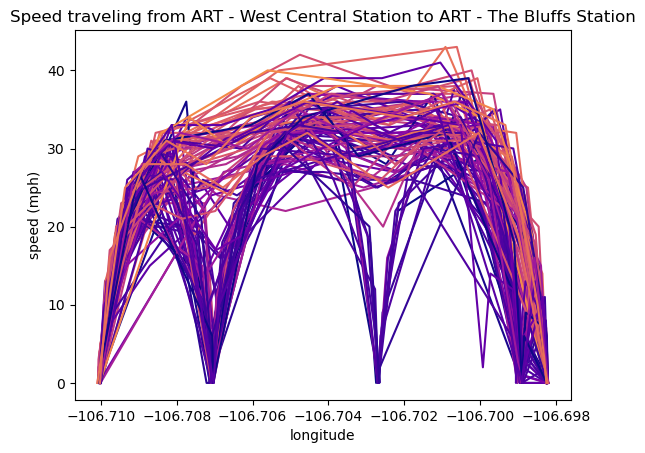

In [203]:
plt.title(f'Speed traveling from {stop1_name} to {stop2_name}')
plt.ylabel('speed (mph)')
plt.xlabel('longitude')
for s in segments:
    plt.plot(s.longitude, s.speed_mph, color=cm.plasma(np.mean(s.speed_mph.to_numpy() - 10)/20))
plt.show()

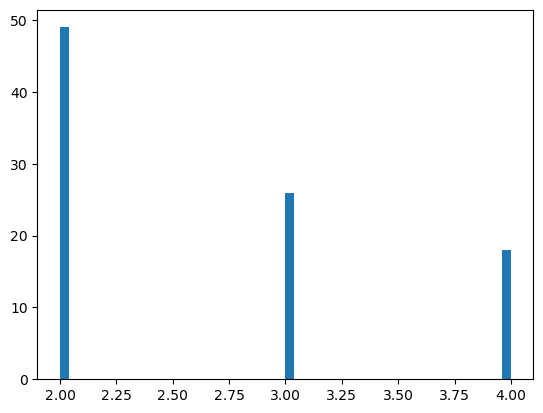

In [190]:
plt.hist([count_stops(s.speed_mph) for s in segments], bins=50)
plt.show()

In [199]:
trip_duration_by_stops = {}
for s in segments:
    nstops = count_stops(s.speed_mph, 5)
    if nstops not in trip_duration_by_stops:
        trip_duration_by_stops[nstops] = []
    trip_duration_by_stops[nstops].append( str2time(s.iloc[-1].msg_time) - str2time(s.iloc[0].msg_time))

print(f'Traveling from {stop1_name} to {stop2_name}')
for n,info in sorted(trip_duration_by_stops.items(), key=lambda x: x[0]):
    print(f'{n-2} intermediate stops:')
    print(f'\tAverage duration: {np.mean(info)}')
    print(f'\tMedian duration: {np.median(info)}')

Traveling from ART - West Central Station to ART - The Bluffs Station
0 intermediate stops:
	Average duration: 115.44680851063829
	Median duration: 112.0
1 intermediate stops:
	Average duration: 168.0344827586207
	Median duration: 176.0
2 intermediate stops:
	Average duration: 188.7058823529412
	Median duration: 192.0


In [231]:
segment_stops = []
for s in segments:
    nstops = count_stops(s.speed_mph, 5)
    if nstops != 3:
        continue
    segment_stops.append((s, where_stops(s,5)[1]))
ag = autocluster([ll2euclid(*s[1]) for s in segment_stops])
print(f'Traveling from {stop1_name} to {stop2_name}')
for i in range(ag.n_clusters_):
    durations = []
    lat = 0
    lng = 0
    for j,(s,w) in enumerate(segment_stops):
        if ag.labels_[j] == i:
            lat += w[0]
            lng += w[1]
            durations.append( str2time(s.msg_time.iloc[-1]) - str2time(s.msg_time.iloc[0]))
    lat /= len(durations)
    lng /= len(durations)
    
#     for n,info in sorted(trip_duration_by_stops.items(), key=lambda x: x[0]):
    print(f'Stop only at {intersection_label(lat,lng)[0]}: ({len(durations)} many)')
    print(f'\tAverage delay: {np.mean(durations) - np.mean(trip_duration_by_stops[2])}')
    print(f'\tMedian delay: {np.median(durations) - np.median(trip_duration_by_stops[2])}')

number of clusters:  3
Traveling from ART - West Central Station to ART - The Bluffs Station
Stop only at 35.08256, -106.69892: (16 many)
	Average delay: 59.17819148936171
	Median delay: 64.0
Stop only at Central @ 63rd: (9 many)
	Average delay: 36.442080378250594
	Median delay: 48.0
Stop only at 35.08171, -106.70269: (4 many)
	Average delay: 62.55319148936171
	Median delay: 68.0


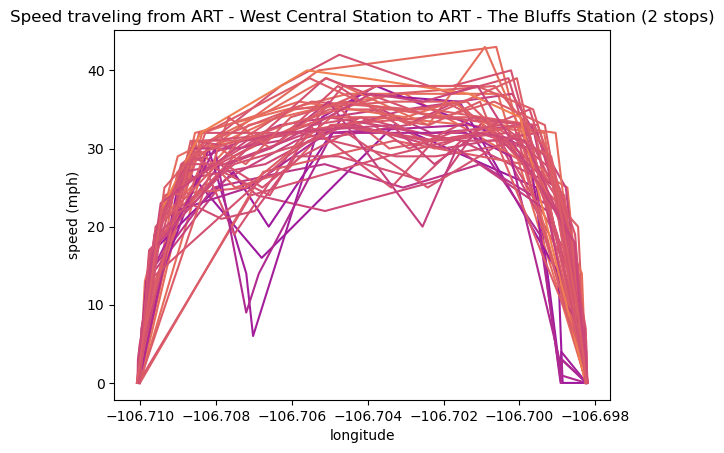

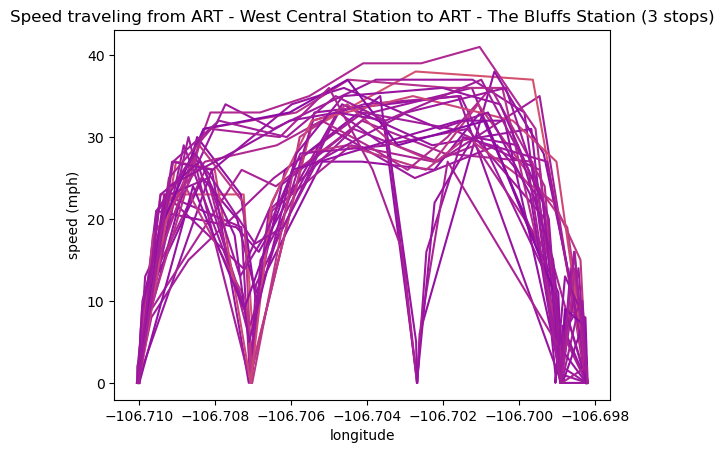

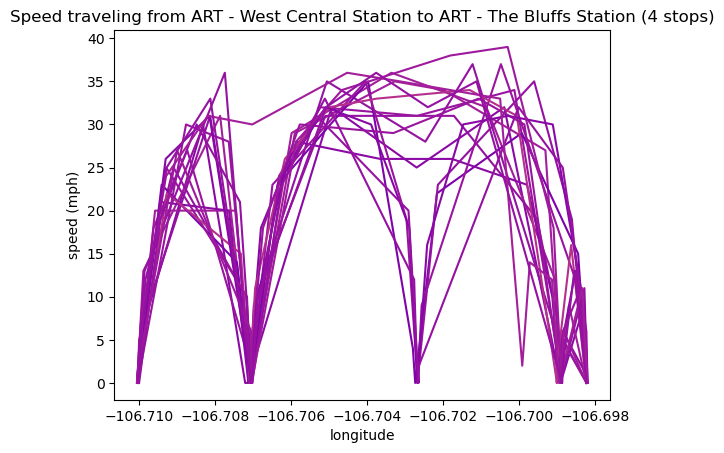

In [197]:
for n in sorted(trip_duration_by_stops):
    
    plt.title(f'Speed traveling from {stop1_name} to {stop2_name} ({n} stops)')
    plt.ylabel('speed (mph)')
    plt.xlabel('longitude')
    for s in segments:
        if count_stops(s.speed_mph, 5) != n:
            continue
        plt.plot(s.longitude, s.speed_mph, color=cm.plasma(60/(str2time(s.iloc[-1].msg_time) - str2time(s.iloc[0].msg_time))))
    plt.show()

# Alright, Full Analysis

In [304]:
# all pairs
segment_info = {}
stop_info = {}
segment_stop_infos = []
# distance_to_stops = []
stop_distance_threshold = 75
for idx2 in tqdm_notebook.tqdm(range(1,len(eb_stops))):
    idx1 = idx2-1
    stop1 = eb_stops[idx1]
    stop1_loc = stoplocations[stop1]
    stop1_name = stopnames[stop1]
    stop2 = eb_stops[idx2]
    stop2_name = stopnames[stop2]
    stop2_loc = stoplocations[stop2]
    segments = []
    for art in tqdm_notebook.tqdm(valid_arts_eb):
        order = uniq(art.next_stop_id.tolist())
        if stop2 not in order:
            continue
        order = order[order.index(stop2):]
        if stop1 in order:
            continue
        d = [geopy.distance.geodesic((stop1_loc['lat'], stop1_loc['lng']), (row.latitude, row.longitude)).feet if row.speed_mph == 0 else 1000 for _,row in art.iterrows() ]
#         distance_to_stops.append(d)
        if min(d) > stop_distance_threshold:
            continue
        stop1_idx = np.argmin(d)
        d = [geopy.distance.geodesic((stop2_loc['lat'], stop2_loc['lng']), (row.latitude, row.longitude)).feet if row.speed_mph == 0 else 1000 for _,row in art.iterrows() ]
#         distance_to_stops.append(d)
        if min(d) > stop_distance_threshold:
            continue
        stop2_idx = np.argmin(d)
        if stop1_idx >= stop2_idx:
            continue
        seg = art.iloc[stop1_idx:stop2_idx+1]
        if (seg.longitude.iloc[1:].to_numpy() - seg.longitude.iloc[:-1].to_numpy()).min() < 0:
            continue

        segments.append(seg)
    # print(len(segments))
    trip_duration_by_stops = {}
    for s in segments:
        stop_locs, seg_dur = full_stop_info(s, 5)
        nstops = len(stop_locs)
        if nstops not in trip_duration_by_stops:
            trip_duration_by_stops[nstops] = []
        trip_duration_by_stops[nstops].append( {'triptime': seg_dur, 'stops': stop_locs})
    segment_info[(stop1, stop2)] = trip_duration_by_stops
#     segment_stops = []
#     for s in segments:
#         nstops = count_stops(s.speed_mph, 5)
#         if nstops != 3:
#             continue
#         segment_stops.append((s, where_stops(s,5)[1]))
    ag = autocluster([ll2euclid(s['lat'], s['lng']) for stop_locs in trip_duration_by_stops.values() \
                      for stop_loc in stop_locs for s in stop_loc['stops']], quiet=True)
#     print(f'Traveling from {stop1_name} to {stop2_name}')
    j=0
    for stop_locs in trip_duration_by_stops.values():
        for stop_loc in stop_locs:
            for s in stop_loc['stops']:
                s['label'] = ag.labels_[j]
                j+=1
    for i in range(ag.n_clusters_):
        durations = []
        lat = 0
        lng = 0
        for j,tripdur_info in enumerate(trip_duration_by_stops.get(3,[])):
            if tripdur_info['stops'][1]['label'] == i:
                lat += tripdur_info['stops'][1]['lat']
                lng += tripdur_info['stops'][1]['lng']
                durations.append( tripdur_info['triptime'])
        if len(durations) == 0:
            continue
        lat /= len(durations)
        lng /= len(durations)
        stop_count = (ag.labels_ == i).sum()
        trip_count = sum([len(t) for t in trip_duration_by_stops.values()])
        segment_stop_infos.append( {'lat': lat, 'lng': lng, 'durations': durations, \
                                    'nonstop_durations': [ t['triptime'] for t in trip_duration_by_stops.get(2,{})], \
                                    'stop1': stop1, 'stop2': stop2, \
                                    'count': stop_count, 'trip_count': trip_count})
    #     for n,info in sorted(trip_duration_by_stops.items(), key=lambda x: x[0]):
    

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

In [305]:
len(segment_stop_infos)

68

In [282]:
segment_stop_infos

[{'lat': 35.0813286,
  'lng': -106.70433183333334,
  'durations': [152, 176, 120],
  'nonstop_durations': [176,
   96,
   104,
   96,
   120,
   97,
   96,
   176,
   125,
   96,
   136,
   128,
   168,
   104,
   112,
   112,
   96,
   128,
   120,
   112,
   112,
   104,
   112,
   97,
   104,
   152,
   112,
   112,
   160,
   96,
   120,
   104,
   112,
   120,
   104,
   80,
   104,
   104,
   152,
   128,
   112,
   112,
   112,
   112,
   112,
   104,
   88,
   104,
   114,
   104,
   120,
   121,
   104,
   112,
   104],
  'stop1': '704230865',
  'stop2': '704230866'},
 {'lat': 35.08195130000001,
  'lng': -106.70158776,
  'durations': [112,
   176,
   184,
   176,
   192,
   160,
   176,
   135,
   152,
   120,
   192,
   184,
   210,
   184,
   168],
  'nonstop_durations': [176,
   96,
   104,
   96,
   120,
   97,
   96,
   176,
   125,
   96,
   136,
   128,
   168,
   104,
   112,
   112,
   96,
   128,
   120,
   112,
   112,
   104,
   112,
   97,
   104,
   152,
   112,


In [267]:
elbow(list(enumerate(sorted([min(d) for d in distance_to_stops]))))

10062

In [268]:
sorted([min(d) for d in distance_to_stops])[10062]

62.61956581231323

In [302]:
last_pair = None
for ssi in sorted(segment_stop_infos, key=lambda x: (eb_stops.index(x['stop1']), (-np.mean(x["durations"]) + np.mean(x["nonstop_durations"]))*x["count"]/x["trip_count"])):
    stop1_name = stopnames[ssi['stop1']]
    stop2_name = stopnames[ssi['stop2']]
    if stop1_name != last_pair:
        print(f'{stop1_name} to {stop2_name}')
    last_pair = stop1_name
    print(f'\tStop only at {intersection_label(ssi["lat"],ssi["lng"])[0]}: ({len(ssi["durations"])} many)')
    print(f'\t\tAverage delay: {np.mean(ssi["durations"]) - np.mean(ssi["nonstop_durations"])}')
    print(f'\t\tMedian delay: {np.median(ssi["durations"]) - np.median(ssi["nonstop_durations"])}')
    print(f'\t\tProbability: {round(ssi["count"]*100/ssi["trip_count"], 2)}%')
    print(f'\t\tExpected delay: {round((np.mean(ssi["durations"]) - np.mean(ssi["nonstop_durations"]))*ssi["count"]/ssi["trip_count"], 2)}')

ART - West Central Station to ART - The Bluffs Station
	Stop only at 35.08256, -106.69892: (19 many)
		Average delay: 56.94928229665071
		Median delay: 64.0
		Probability: 40.35%
		Expected delay: 22.98
	Stop only at Central @ 63rd: (11 many)
		Average delay: 41.32727272727273
		Median delay: 48.0
		Probability: 28.07%
		Expected delay: 11.6
	Stop only at 35.0817, -106.7027: (7 many)
		Average delay: 56.483116883116864
		Median delay: 64.0
		Probability: 12.28%
		Expected delay: 6.94
ART - The Bluffs Station to ART - Town of Atrisco Station
	Stop only at Central @ Atrisco: (1 many)
		Average delay: 6.773333333333326
		Median delay: 8.0
		Probability: 100.75%
		Expected delay: 6.82
	Stop only at 35.08511, -106.68755: (19 many)
		Average delay: 38.45754385964911
		Median delay: 40.0
		Probability: 17.16%
		Expected delay: 6.6
	Stop only at 35.08327, -106.69574: (14 many)
		Average delay: 30.773333333333326
		Median delay: 27.5
		Probability: 20.9%
		Expected delay: 6.43
	Stop only at 35.

	Stop only at Central @ Monroe: (33 many)
		Average delay: 32.72086580086578
		Median delay: 24.0
		Probability: 15.79%
		Expected delay: 5.17
	Stop only at ART - San Mateo Station: (1 many)
		Average delay: 32.20571428571428
		Median delay: 32.0
		Probability: 5.74%
		Expected delay: 1.85
ART - San Mateo Station to ART - San Pedro Station
	Stop only at 35.07734, -106.58205: (93 many)
		Average delay: 30.175478780937837
		Median delay: 26.0
		Probability: 35.21%
		Expected delay: 10.62
	Stop only at 35.07736, -106.58254: (2 many)
		Average delay: 41.3905325443787
		Median delay: 40.0
		Probability: 0.75%
		Expected delay: 0.31
	Stop only at 35.07704, -106.57955: (2 many)
		Average delay: 1.3905325443787007
		Median delay: 0.0
		Probability: 1.87%
		Expected delay: 0.03
ART - San Pedro Station to ART - International District Station
	Stop only at ART - International District Station: (2 many)
		Average delay: 32.35593220338983
		Median delay: 36.0
		Probability: 101.13%
		Expected delay

In [303]:
last_pair = None
for ssi in sorted(segment_stop_infos, key=lambda x: ((-np.mean(x["durations"]) + np.mean(x["nonstop_durations"]))*x["count"]/x["trip_count"])):
    stop1_name = stopnames[ssi['stop1']]
    stop2_name = stopnames[ssi['stop2']]
    if stop1_name != last_pair:
        print(f'{stop1_name} to {stop2_name}')
    last_pair = stop1_name
    print(f'\tStop only at {intersection_label(ssi["lat"],ssi["lng"])[0]}: ({len(ssi["durations"])} many)')
    print(f'\t\tAverage delay: {np.mean(ssi["durations"]) - np.mean(ssi["nonstop_durations"])}')
    print(f'\t\tMedian delay: {np.median(ssi["durations"]) - np.median(ssi["nonstop_durations"])}')
    print(f'\t\tProbability: {round(ssi["count"]*100/ssi["trip_count"], 2)}%')
    print(f'\t\tExpected delay: {round((np.mean(ssi["durations"]) - np.mean(ssi["nonstop_durations"]))*ssi["count"]/ssi["trip_count"], 2)}')

ART - UNM Popejoy Station to ART - Nob Hill Station
	Stop only at 35.0805, -106.61025: (1 many)
		Average delay: 50.775000000000006
		Median delay: 60.0
		Probability: 99.5%
		Expected delay: 50.52
ART - San Pedro Station to ART - International District Station
	Stop only at ART - International District Station: (2 many)
		Average delay: 32.35593220338983
		Median delay: 36.0
		Probability: 101.13%
		Expected delay: 32.72
ART - West Central Station to ART - The Bluffs Station
	Stop only at 35.08256, -106.69892: (19 many)
		Average delay: 56.94928229665071
		Median delay: 64.0
		Probability: 40.35%
		Expected delay: 22.98
ART - San Pedro Station to ART - International District Station
	Stop only at Central @ San Pedro: (120 many)
		Average delay: 38.92259887005649
		Median delay: 40.0
		Probability: 50.75%
		Expected delay: 19.75
ART - International District Station to Central @ Wyoming (ART)
	Stop only at Central @ Wyoming: (82 many)
		Average delay: 45.420214964861515
		Median delay: 

	Stop only at 35.08704, -106.68298: (7 many)
		Average delay: 35.28778467908903
		Median delay: 56.0
		Probability: 8.49%
		Expected delay: 3.0
ART - San Pedro Station to ART - International District Station
	Stop only at Central @ California: (11 many)
		Average delay: 31.17411402157164
		Median delay: 32.0
		Probability: 9.4%
		Expected delay: 2.93
ART - EDo Station to ART - Presbyterian Station
	Stop only at Central @ High: (10 many)
		Average delay: 17.799999999999997
		Median delay: 24.0
		Probability: 15.9%
		Expected delay: 2.83
	Stop only at 35.08262, -106.63669: (9 many)
		Average delay: 20.66666666666667
		Median delay: 24.0
		Probability: 10.77%
		Expected delay: 2.23
ART - International District Station to Central @ Wyoming (ART)
	Stop only at 35.07482, -106.55948: (22 many)
		Average delay: 21.0100154083205
		Median delay: 21.5
		Probability: 10.2%
		Expected delay: 2.14
ART - Barelas Station to ART - Alvarado Transportation Center
	Stop only at Gold @ 5th: (8 many)
		Aver

In [315]:
last_pair = None
total_mean_dur = 0
total_median_dur=0
for (stop1,stop2), tripdur_bystop in segment_info.items():
    stop1_name = stopnames[stop1]
    stop2_name = stopnames[stop2]
    print(f'{stop1_name} to {stop2_name}')
    nonstop_durs = [t['triptime'] for t in tripdur_bystop[2]]
    all_durs = [t['triptime'] for tripdur in tripdur_bystop.values() for t in tripdur]
    print(f'\tAverage time lost: {np.mean(all_durs) - np.mean(nonstop_durs)}')
    print(f'\tMedian time lost: {np.median(all_durs) - np.median(nonstop_durs)}')
    total_mean_dur += np.mean(all_durs) - np.mean(nonstop_durs)
    total_median_dur += np.median(all_durs) - np.median(nonstop_durs)
print()
print('Total average time lost: ', total_mean_dur / 60, ' minutes')
print('Total median time lost: ', total_median_dur / 60, ' minutes')

ART - West Central Station to ART - The Bluffs Station
	Average time lost: 30.78261562998405
	Median time lost: 36.0
ART - The Bluffs Station to ART - Town of Atrisco Station
	Average time lost: 16.892736318407955
	Median time lost: 16.0
ART - Town of Atrisco Station to ART - BioPark Station
	Average time lost: 11.965682253213018
	Median time lost: 8.0
ART - BioPark Station to ART - Old Town Station
	Average time lost: 26.870901639344254
	Median time lost: 24.0
ART - Old Town Station to ART - West Downtown Station
	Average time lost: 18.300940438871464
	Median time lost: 8.0
ART - West Downtown Station to ART - Barelas Station
	Average time lost: 35.60384615384615
	Median time lost: 32.0
ART - Barelas Station to ART - Alvarado Transportation Center
	Average time lost: 13.183020637898679
	Median time lost: 0.0
ART - Alvarado Transportation Center to ART - EDo Station
	Average time lost: 25.76473971814781
	Median time lost: 32.0
ART - EDo Station to ART - Presbyterian Station
	Average ti

# Full analysis westbound

100%|█████████████████████| 489/489 [00:00<00:00, 10257.48it/s]


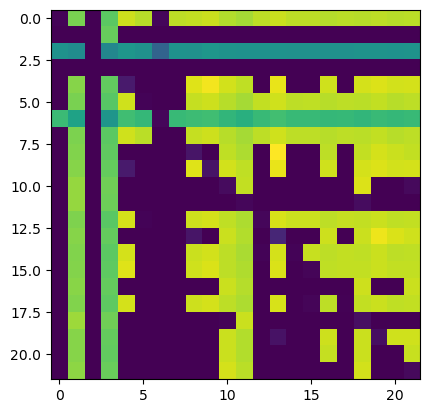

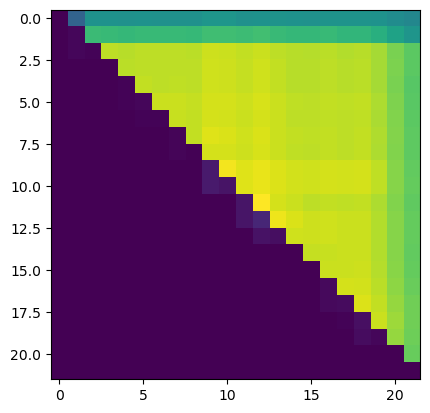

Tramway @ Wenonah (ART)
Central @ Juan Tabo  (ART)
Central @ Eubank  (ART)
Central @ Wyoming (ART)
ART - International District Station
ART - San Pedro Station
ART - San Mateo Station
ART - Highland Station
ART - Nob Hill East Station
ART - Nob Hill Station
ART - UNM Popejoy Station
ART - UNM / CNM Station
ART - Presbyterian Station
ART - EDo Station
ART - Downtown Station
ART - Main Library Station
ART - West Downtown Station
ART - Old Town Station
ART - BioPark Station
ART - Town of Atrisco Station
ART - The Bluffs Station
ART - West Central Station


In [318]:
# now let's look at consecutive stops

wb_allstops = set()
for art in tqdm(valid_arts_wb):
    wb_allstops = wb_allstops.union(art.next_stop_id.tolist())
wb_allstops = list(wb_allstops)
priority = np.zeros((len(wb_allstops), len(wb_allstops)))

    
for art in tqdm(valid_arts_wb):
    order = uniq(art.next_stop_id.tolist())
    if len(order) > 28:
        continue
    for i,s1 in enumerate(order):
        idx1 = wb_allstops.index(s1)
        for s2 in order[i+1:]:
            idx2 = wb_allstops.index(s2)
#             assert idx1 != idx2
            priority[idx1,idx2] += 1
            

plt.imshow(priority)
plt.show()

wb_order = np.argsort(np.linalg.norm(priority, axis=0, ord=0.1))
plt.imshow(priority[wb_order][:,wb_order])
plt.show()
wb_stops = [wb_allstops[i] for i in wb_order if 'ART' in stopnames[wb_allstops[i]]]
for i in wb_stops:
    print(stopnames[i])


In [319]:
# all pairs
segment_info = {}
stop_info = {}
segment_stop_infos = []
# distance_to_stops = []
stop_distance_threshold = 75
for idx2 in tqdm_notebook.tqdm(range(1,len(wb_stops))):
    idx1 = idx2-1
    stop1 = wb_stops[idx1]
    stop1_loc = stoplocations[stop1]
    stop1_name = stopnames[stop1]
    stop2 = wb_stops[idx2]
    stop2_name = stopnames[stop2]
    stop2_loc = stoplocations[stop2]
    segments = []
    for art in tqdm_notebook.tqdm(valid_arts_wb):
        order = uniq(art.next_stop_id.tolist())
        if stop2 not in order:
            continue
        order = order[order.index(stop2):]
        if stop1 in order:
            continue
        d = [geopy.distance.geodesic((stop1_loc['lat'], stop1_loc['lng']), (row.latitude, row.longitude)).feet if row.speed_mph == 0 else 1000 for _,row in art.iterrows() ]
#         distance_to_stops.append(d)
        if min(d) > stop_distance_threshold:
            continue
        stop1_idx = np.argmin(d)
        d = [geopy.distance.geodesic((stop2_loc['lat'], stop2_loc['lng']), (row.latitude, row.longitude)).feet if row.speed_mph == 0 else 1000 for _,row in art.iterrows() ]
#         distance_to_stops.append(d)
        if min(d) > stop_distance_threshold:
            continue
        stop2_idx = np.argmin(d)
        if stop1_idx >= stop2_idx:
            continue
        seg = art.iloc[stop1_idx:stop2_idx+1]
        if (-seg.longitude.iloc[1:].to_numpy() + seg.longitude.iloc[:-1].to_numpy()).min() < 0:
            continue

        segments.append(seg)
    # print(len(segments))
    trip_duration_by_stops = {}
    for s in segments:
        stop_locs, seg_dur = full_stop_info(s, 5)
        nstops = len(stop_locs)
        if nstops not in trip_duration_by_stops:
            trip_duration_by_stops[nstops] = []
        trip_duration_by_stops[nstops].append( {'triptime': seg_dur, 'stops': stop_locs})
    segment_info[(stop1, stop2)] = trip_duration_by_stops
#     segment_stops = []
#     for s in segments:
#         nstops = count_stops(s.speed_mph, 5)
#         if nstops != 3:
#             continue
#         segment_stops.append((s, where_stops(s,5)[1]))
    ag = autocluster([ll2euclid(s['lat'], s['lng']) for stop_locs in trip_duration_by_stops.values() \
                      for stop_loc in stop_locs for s in stop_loc['stops']], quiet=True)
#     print(f'Traveling from {stop1_name} to {stop2_name}')
    j=0
    for stop_locs in trip_duration_by_stops.values():
        for stop_loc in stop_locs:
            for s in stop_loc['stops']:
                s['label'] = ag.labels_[j]
                j+=1
    for i in range(ag.n_clusters_):
        durations = []
        lat = 0
        lng = 0
        for j,tripdur_info in enumerate(trip_duration_by_stops.get(3,[])):
            if tripdur_info['stops'][1]['label'] == i:
                lat += tripdur_info['stops'][1]['lat']
                lng += tripdur_info['stops'][1]['lng']
                durations.append( tripdur_info['triptime'])
        if len(durations) == 0:
            continue
        lat /= len(durations)
        lng /= len(durations)
        stop_count = (ag.labels_ == i).sum()
        trip_count = sum([len(t) for t in trip_duration_by_stops.values()])
        segment_stop_infos.append( {'lat': lat, 'lng': lng, 'durations': durations, \
                                    'nonstop_durations': [ t['triptime'] for t in trip_duration_by_stops.get(2,{})], \
                                    'stop1': stop1, 'stop2': stop2, \
                                    'count': stop_count, 'trip_count': trip_count})
    #     for n,info in sorted(trip_duration_by_stops.items(), key=lambda x: x[0]):
    

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

In [322]:
last_pair = None
total_mean_dur = 0
total_median_dur=0
for (stop1,stop2), tripdur_bystop in segment_info.items():
    stop1_name = stopnames[stop1]
    stop2_name = stopnames[stop2]
    print(f'{stop1_name} to {stop2_name}')
    if min(tripdur_bystop) > 2:
        print(f'\tNote - no nonstop trips found; using {min(tripdur_bystop)-2} stops as baseline')
    nonstop_durs = [t['triptime'] for t in tripdur_bystop[min(tripdur_bystop)]]
    all_durs = [t['triptime'] for tripdur in tripdur_bystop.values() for t in tripdur]
    print(f'\tAverage time lost: {np.mean(all_durs) - np.mean(nonstop_durs)}')
    print(f'\tMedian time lost: {np.median(all_durs) - np.median(nonstop_durs)}')
    total_mean_dur += np.mean(all_durs) - np.mean(nonstop_durs)
    total_median_dur += np.median(all_durs) - np.median(nonstop_durs)
print()
print('Total average time lost: ', total_mean_dur / 60, ' minutes')
print('Total median time lost: ', total_median_dur / 60, ' minutes')

Tramway @ Wenonah (ART) to Central @ Juan Tabo  (ART)
	Note - no nonstop trips found; using 1 stops as baseline
	Average time lost: 0.0
	Median time lost: 0.0
Central @ Juan Tabo  (ART) to Central @ Eubank  (ART)
	Average time lost: 26.93782249742003
	Median time lost: 32.0
Central @ Eubank  (ART) to Central @ Wyoming (ART)
	Average time lost: 20.91414173228347
	Median time lost: 8.0
Central @ Wyoming (ART) to ART - International District Station
	Average time lost: 35.47564234326822
	Median time lost: 48.0
ART - International District Station to ART - San Pedro Station
	Average time lost: 31.000624785230087
	Median time lost: 24.0
ART - San Pedro Station to ART - San Mateo Station
	Average time lost: 15.35744613434727
	Median time lost: 16.0
ART - San Mateo Station to ART - Highland Station
	Average time lost: 8.482654600301657
	Median time lost: 0.0
ART - Highland Station to ART - Nob Hill East Station
	Average time lost: 3.8819952774498176
	Median time lost: 1.0
ART - Nob Hill East 